In [358]:
# Import necessary libraries
import pandas as pd
import numpy as np
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

from typing import List, Tuple
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, recall_score, f1_score, make_scorer
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

##### Datensatz

In [359]:
# Load data
data = pd.read_csv("data/reservations.csv", header=0, sep=",")

In [360]:
def get_data_statistics(data: pd.DataFrame) -> Tuple[Tuple[int, int], int, pd.DataFrame, pd.Series]:
    """
    Returns statistics for the input DataFrame.

    Parameters:
    -----------
        data: pd.DataFrame
            The original dataset to be analyzed.

    Returns:
    --------
        shape: Tuple[int, int]
            A tuple containing the number of rows and columns in the DataFrame.
        total_missing_values: int
            The total number of missing values in the DataFrame.
        duplicate_rows: pd.DataFrame
            A DataFrame containing the duplicate rows in the input DataFrame.
        target_count: pd.Series
            A Series containing the count of each unique value in the 'booking_status' column.
    """
    
    shape = data.shape
    total_missing_values = data.isnull().sum().sum()
    duplicate_rows = data[data.duplicated()]
    target_count = data.booking_status.value_counts()

    return shape, total_missing_values, duplicate_rows, target_count

shape, total_missing_values, duplicate_rows, target_count = get_data_statistics(data)

print(f"[SHAPE]\t\t\t\t {shape[0]} rows and {shape[1]} columns")
print(f"[MISSING VALUES]\t\t {total_missing_values} total missing values")
print(f"[DUPLICATES]\t\t\t {duplicate_rows.shape[0]} duplicate rows\n")

def get_column_categories(data: pd.DataFrame) -> dict:
    """
    Returns a dictionary of all categorical columns.

    Parameters:
    -----------
        data: pd.DataFrame
            The original dataset to be analyzed.

    Returns:
    --------
        dict: 
            A dictionary of all categorical columns.
    """
    
    numerical_features = data.select_dtypes(include=['int64', 'float64'])
    categorical_features = data.select_dtypes(include=['object'])
    
    return {
        'num_of_numerical_features': numerical_features.shape[1],
        'numerical_features': numerical_features.columns.values,
        'num_of_categorical_columns': categorical_features.shape[1],
        'categorical_columns': categorical_features.columns.values,
    }

column_categories = get_column_categories(data)

print("[{} NUMERICAL COLUMNS]\n {}\n".format(column_categories['num_of_numerical_features'], column_categories['numerical_features']))
print("[{} CATEGORICAL COLUMNS]\n {}\n".format(column_categories['num_of_categorical_columns'], column_categories['categorical_columns']))

[SHAPE]				 36275 rows and 19 columns
[MISSING VALUES]		 0 total missing values
[DUPLICATES]			 0 duplicate rows

[14 NUMERICAL COLUMNS]
 ['no_of_adults' 'no_of_children' 'no_of_weekend_nights'
 'no_of_week_nights' 'required_car_parking_space' 'lead_time'
 'arrival_year' 'arrival_month' 'arrival_date' 'repeated_guest'
 'no_of_previous_cancellations' 'no_of_previous_bookings_not_canceled'
 'avg_price_per_room' 'no_of_special_requests']

[5 CATEGORICAL COLUMNS]
 ['Booking_ID' 'type_of_meal_plan' 'room_type_reserved'
 'market_segment_type' 'booking_status']



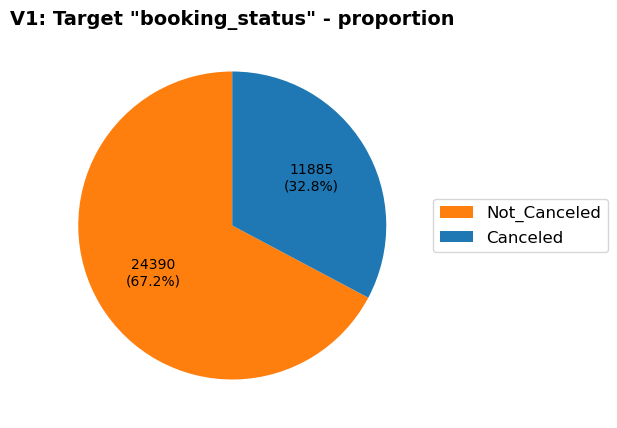

In [361]:
def plot_target_proportion(target_count: pd.Series) -> None:
    """
    Plots the target variable proportion.

    Parameters:
    -----------
        target_count: pd.Series
            A Series containing the count of each unique value in the 'booking_status' column.
    """
    
    plt.figure(figsize=(6, 5))
    patches, texts, autotexts = plt.pie(target_count.values, 
                                        labels=None, 
                                        colors=['#FF7F0E', '#1F77B4'],  
                                        autopct='%1.1f%%', 
                                        startangle=90)

    # Add numerical values to the pie chart
    for i, v in enumerate(target_count.values):
        autotexts[i].set_text(str(v) + "\n(" + str(round(v / target_count.values.sum() * 100, 1)) + "%)")

    plt.title("V1: Target \"booking_status\" - proportion", fontsize=14, fontweight='bold')
    plt.legend(patches, target_count.index, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.show()

plot_target_proportion(target_count)


In [362]:
'''
NOTE: The idea of displaying the feature´s distribution using a histogram and a boxplot - broken down by category of target variable - is 
inspired by the following notebook: https://www.kaggle.com/code/the314arham/eda-prediction-knn-ann-xgb-lgbm-91-acc.
However, the selection of the relevant features as well as the (codewise) implementation of the functions was done by myself!
'''

'\nNOTE: The idea of displaying the feature´s distribution using a histogram and a boxplot - broken down by category of target variable - is \ninspired by the following notebook: https://www.kaggle.com/code/the314arham/eda-prediction-knn-ann-xgb-lgbm-91-acc.\nHowever, the selection of the relevant features as well as the (codewise) implementation of the functions was done by myself!\n'

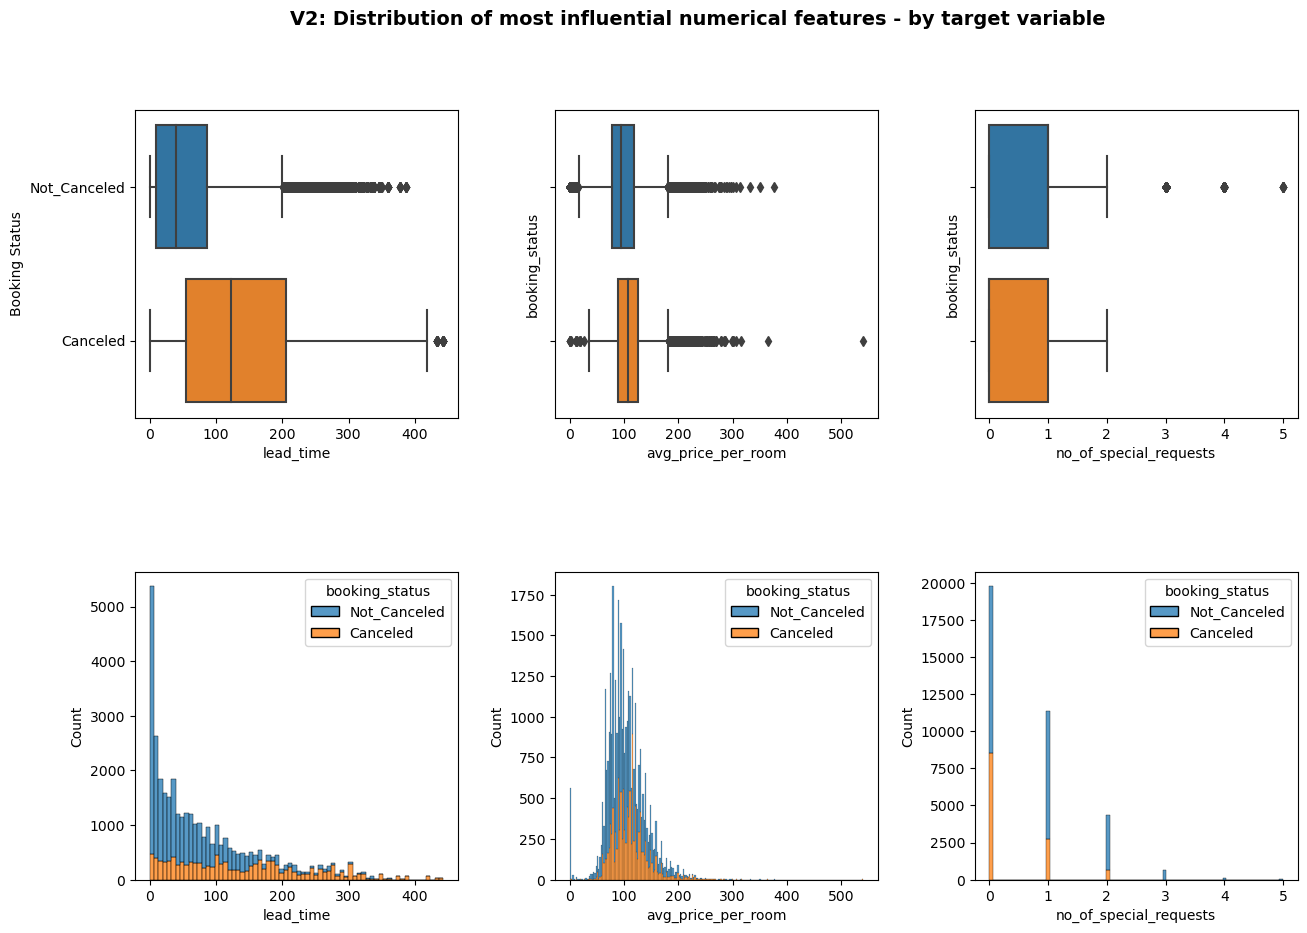

In [363]:
def plot_numerical_features_by_target(data: pd.DataFrame, numerical_features: List[str]) -> None:
    """
    Plots boxplots and histograms for a list of the most influential numerical features (see correlation matrix).

    Parameters:
    -----------
        data: pd.DataFrame
            The dataset to be analyzed.
        numerical_features: List[str]
            The list of numerical features.
    """
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("V2: Distribution of most influential numerical features - by target variable", fontsize=14, fontweight='bold')
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.3)

    for i, feature in enumerate(numerical_features):
        sns.boxplot(x=data[feature], y=data.booking_status, ax=ax[0, i])
        if i == 0:
            ax[0, i].set_ylabel("Booking Status")
        else:
            ax[0, i].set(yticklabels=[])
        sns.histplot(data=data, x=feature, hue="booking_status", ax=ax[1, i], multiple="stack")

    plt.show()

plot_numerical_features_by_target(data, ["lead_time", "avg_price_per_room", "no_of_special_requests" ])

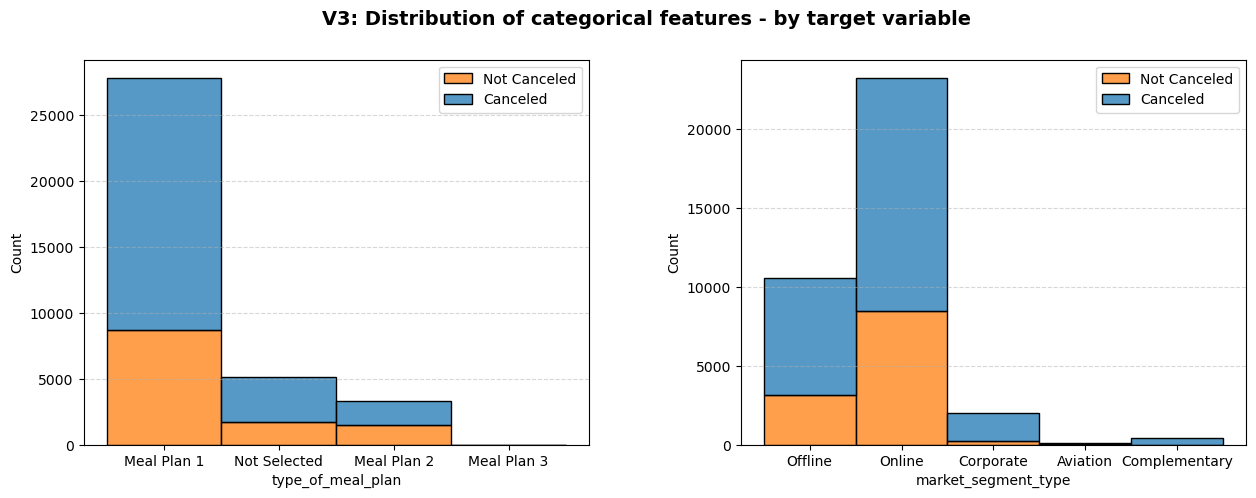

In [364]:
def plot_categorical_features_by_target(data: pd.DataFrame, categorical_features: List[str]) -> None:
    """
    Plots histograms for a selection of categorical features.

    Parameters:
    -----------
        data: pd.DataFrame
            The dataset to be analyzed.
        categorical_features: List[str]
            The list of categorical features.
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("V3: Distribution of categorical features - by target variable", fontsize=14, fontweight='bold')
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.3)

    for i, feature in enumerate(categorical_features):
        sns.histplot(data=data, x=feature, hue="booking_status", ax=ax[i], legend=False, multiple="stack")
        ax[i].grid(axis='y', linestyle='--', alpha=0.5)
        ax[i].legend(loc='upper right', fontsize=10, labels=['Not Canceled', 'Canceled'])

    plt.show()

plot_categorical_features_by_target(data, ["type_of_meal_plan", "market_segment_type"])

##### Datenvorverarbeitung und Feature Engineering

In [365]:
def label_encode_column(data: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Encodes the specified column of a DataFrame using LabelEncoder.

    Parameters:
    -----------
        data: pd.DataFrame
            A pandas DataFrame containing the data to be encoded.
        column_name: str 
            A string specifying the name of the column to be encoded.

    Returns:
    --------
        data: pd.DataFrame
            A copy of the input DataFrame with the specified column encoded.
    """

    le = LabelEncoder()
    data[column_name] = le.fit_transform(data[column_name])

    return data

data = label_encode_column(data, 'booking_status')

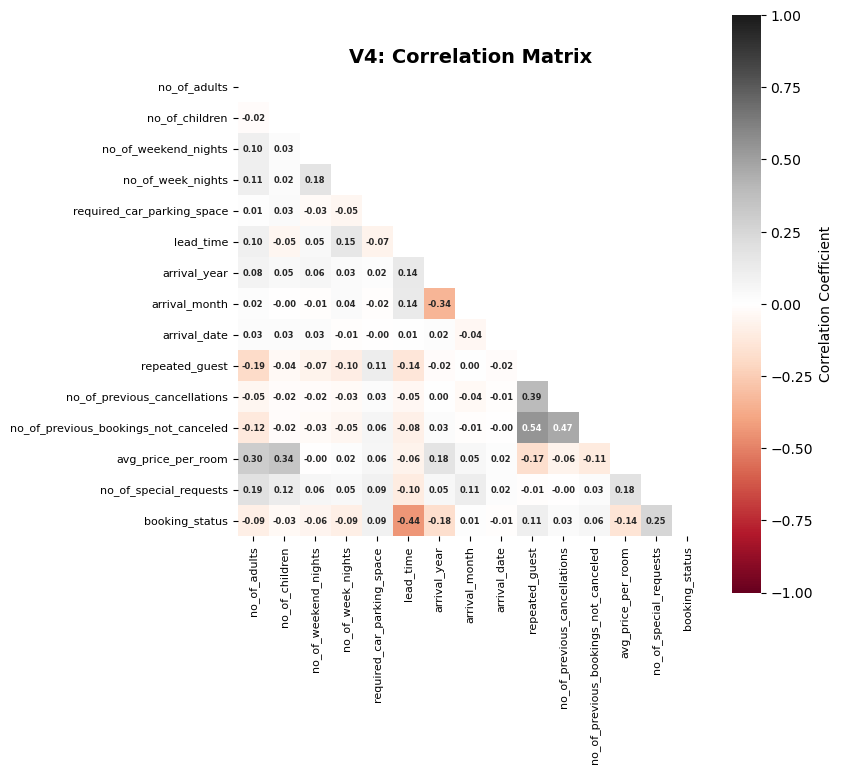

In [366]:
def plot_correlation_matrix(data: pd.DataFrame) -> None:
    """
    Plots a correlation matrix for the numerical features.

    Parameters:
    -----------
        data: pd.DataFrame
            The dataset to be analyzed.
    """
    
    corr = data.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr, mask=mask, cmap='RdGy', vmin=-1, vmax=1, annot=True,
                annot_kws={'fontsize':6, 'fontweight':'bold'}, cbar_kws={'label': 'Correlation Coefficient'},
               square=True, fmt='.2f')

    plt.title('V4: Correlation Matrix', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.gcf().set_size_inches(7.5, 7.5)
    plt.show()

plot_correlation_matrix(data)

In [367]:
# Create conditions based on the values in the 'arrival_month' column
conditions = [
    (data['arrival_month'] <= 3),
    (data['arrival_month'] > 3) & (data['arrival_month'] <= 6),
    (data['arrival_month'] > 6) & (data['arrival_month'] <= 9),
    (data['arrival_month'] >= 10)
    ]
values = ['Q1', 'Q2', 'Q3', 'Q4']

# Create a new categorical column 'quarter' based on the conditions and their corresponding values
data['quarter'] = np.select(conditions, values)

# Drop the 'arrival_month' column
data = data.drop(['arrival_month'], axis=1)

In [368]:
# Separating the features and labels from the data
features = data.drop(columns=['booking_status', 'Booking_ID'], axis=1)
labels = data['booking_status']

In [369]:
def encode_cat_data(features: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the features by one-hot encoding categorical variables.

    Parameters:
    -----------
        features: pd.DataFrame
            The features to preprocess. This should contain a mix of numerical and categorical variables.

    Returns:
    --------   
        preprocessed_features: pd.DataFrame
            The preprocessed features, with all categorical variables one-hot encoded and concatenated 
            with the original numerical variables.
    """
    
    # Select categorical and numerical features
    features_cat = features.select_dtypes(include=['object'])
    features_numeric = features.select_dtypes(include=['int64', 'float64'])   
    
    # One-hot encode categorical features
    cat_encoder = OneHotEncoder(sparse_output=False)
    features_cat_encoded = cat_encoder.fit_transform(features_cat)
    features_cat_df = pd.DataFrame(features_cat_encoded, columns=cat_encoder.get_feature_names_out(features_cat.columns.values))
    
    # Concatenate numerical and one-hot encoded categorical features
    preprocessed_features = pd.concat([features_numeric, features_cat_df], axis=1)
    
    return preprocessed_features

features = encode_cat_data(features)

In [370]:
def select_features_chi2(features: pd.DataFrame, labels: pd.Series , alpha: float = 0.05) -> Tuple[pd.Series, List[str]]:
    """
    Performs chi-square feature selection and returns selected features.

    Parameters:
    -----------
        features: pd.DataFrame) 
            The input DataFrame of features.
        labels: pd.Series
            The input Series of labels.
        alpha: float, default = 0.05
            The significance level for the chi-square test. Defaults to 0.05.

    Returns:
    --------
        p_values: pd.Series[float]
            A Series containing the p-values for each feature.
        selected_features: list[str]
            A list containing the selected features.

    Notes:
    -----
        Chi-square feature selection is a statistical method used to identify the most important
        features in a dataset. It measures the dependence between the feature and the target variable
        by calculating the chi-square statistic and the corresponding p-value. The lower the p-value,
        the more likely it is that the feature is important in relation to the target variable. 
    """

    # Calculate chi-square statistic and p-values
    chi_scores, p_values = chi2(features, labels)

    # Select features with p-values less than the significance level
    p_values = pd.Series(p_values, index=features.columns)
    selected_features = p_values[p_values < alpha].index.tolist()

    return p_values, selected_features

p_values, selected_features = select_features_chi2(features, labels)

# Top 11 features with highest chi-square p-values
p_values_sorted = p_values.sort_values(ascending=False)[:11]

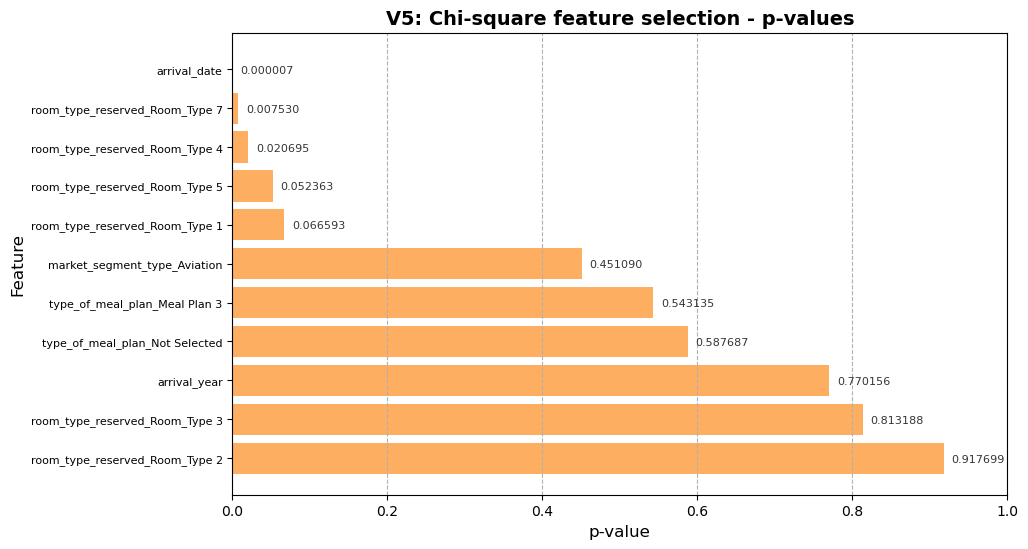

In [371]:
def plot_feature_importance(p_values: pd.Series) -> None:
    """
    Plots the p-values for each feature.

    Parameters:
    -----------
        p_values: pd.Series[float]
            A Series containing the p-values for each feature.

    """

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(p_values.index, p_values.values, color='#fdae61')

    # Add values next to the bars
    for i, v in enumerate(p_values.values):
        ax.text(v + 0.01, i - 0.1, f'{v:.6f}', color='#333333', fontsize=8)

    ax.set_title('V5: Chi-square feature selection - p-values', fontsize=14, fontweight='bold')
    ax.set_xlabel('p-value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12) 
    ax.set_xlim(0, 1)
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='y', labelsize=8)
    plt.show()

plot_feature_importance(p_values_sorted)

In [372]:
# Drop features with high p-values and low contextual relevance
cols_to_drop = ["room_type_reserved_Room_Type 2", 'room_type_reserved_Room_Type 3', 'type_of_meal_plan_Not Selected', 
            'type_of_meal_plan_Meal Plan 3','room_type_reserved_Room_Type 5']
features = features.drop(cols_to_drop, axis=1)

In [373]:
def scale_and_oversample(X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Scales and oversamples the input features and target values.

    Parameters:
    -----------
    X : pandas.DataFrame
        Input features.
    y : pandas.Series
        Target values.

    Returns:
    --------
    X : pandas.DataFrame
        Scaled and oversampled input features.
    y : pandas.Series
        Scaled and oversampled target values.
    """

    scaler = StandardScaler()
    oversampler = SMOTE(random_state=42) 

    X = scaler.fit_transform(X)
    X, y = oversampler.fit_resample(X, y)

    return X, y

preprocessed_features, target = scale_and_oversample(features, labels)

##### Split des Datensatzes

In [374]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_features, target, test_size=0.2, random_state=42)

print("[TRAINING]\t {} samples".format(X_train.shape[0]))
print("[TEST]\t\t {} samples".format(X_test.shape[0]))

[TRAINING]	 39024 samples
[TEST]		 9756 samples


##### Training des ML-Modells und Tuning der Hyperparameter

In [375]:
def train_model(X_train: pd.DataFrame, y_train: pd.Series, params: dict) -> None:
    """
    Trains a Random Forest model (5-fold cross-validation) based on the input hyperparameters and logs the results to MLflow.

    Parameters:
    -----------
        X_train: pd.DataFrame
            The training features.
        y_train: pd.Series
            The training labels.
        params: dict
            A dictionary containing the hyperparameters to be used for training, consisting of the following keys:
                - n_estimators: list[int]
                    A list of integers representing the number of trees in the forest.
                - max_depth: list[int]
                    A list of integers representing the maximum depth of each tree.
                - max_features: list[str]
                    A list of strings representing the number of features to consider when looking for the best split.
    """
    
    for value in params["n_estimators"]:
        for depth in params["max_depth"]:
            for feature in params["max_features"]:

                with mlflow.start_run():

                    # Initialize model with hyperparameters
                    model = RandomForestClassifier(n_estimators=value, max_depth=depth, max_features=feature, random_state=42)
                    
                    # Train model
                    model.fit(X_train, y_train)

                    # 5-fold cross-validation with recall and f1 scores
                    scoring = {'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score)} 
                    scores = cross_validate(model, X_train, y_train, scoring=scoring, return_estimator=False, cv=5)

                    # Log hyperparameters
                    mlflow.log_param("n_estimators", value)
                    mlflow.log_param("max_depth", depth)
                    mlflow.log_param("max_features", feature)
                    
                    # Log mean recall and f1 scores for sum of folds for each hyperparameter combination
                    mlflow.log_metric("recall", scores["test_recall"].mean())
                    mlflow.log_metric("f1", scores["test_f1"].mean())
             

                    # Log model to registry
                    mlflow.sklearn.log_model(sk_model= RandomForestClassifier(n_estimators=value, 
                                                                              max_depth=depth, 
                                                                              max_features=feature, 
                                                                              random_state=42), 
                                            artifact_path="rfc_reservations_classifier", 
                                            registered_model_name=f"hotel-booking-model-{value}-{depth}-{feature}")
                    

# Hyperparameters to use for training
params = {
    "n_estimators": np.arange(50, 400, 50),
    "max_depth": np.arange(1, 20, 5),
    "max_features": ["sqrt", "log2"],
}

train_model(X_train, y_train, params)

Exception: '/Users/pahl/workspace/DataExplorationProject/mlruns' does not exist.

{'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 200}

In [ ]:
model_name = "hotel-booking-model-200-16-sqrt"
model_version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

Exception: '/Users/pahl/workspace/DataExplorationProject/mlruns' does not exist.

In [ ]:
# def train_model(X_train: pd.DataFrame, y_train: pd.Series, params: dict) -> GridSearchCV:
#     """
#     Trains a Random Forest model using GridSearchCV and logs the results to MLflow.

#     Parameters:
#     -----------
#         X_train: pd.DataFrame
#             The training features.
#         y_train: pd.Series
#             The training labels.
#         params: dict
#             The hyperparameters to use for training.

#     Returns:
#     --------
#         grid: GridSearchCV
#             A GridSearchCV object containing the trained model and hyperparameters.
#     """
    
#     with mlflow.start_run():

#         rfc = RandomForestClassifier(random_state=42)

#         # Define the scoring metrics
#         scoring = {'recall': make_scorer(recall_score), 'precision': make_scorer(f1_score), 'refit_metric': make_scorer(recall_score)} 

#         # Define and fit the GridSearchCV object
#         grid = GridSearchCV(rfc, params, cv=5, scoring=scoring, n_jobs=-1, verbose=10, refit='refit_metric')
#         grid.fit(X_train, y_train)

#         # Log parameters
#         for key, value in params.items():
#             mlflow.log_param(key, value)

#         # Log recall and f1 score for each parameter set in training and validation data
#         for i, params in enumerate(grid.cv_results_['params']):
#             mlflow.log_metric(f"train_recall_{i}", grid.cv_results_['split0_test_recall'][i])
#             mlflow.log_metric(f"train_f1_{i}", grid.cv_results_['split0_test_precision'][i])
#             mlflow.log_metric(f"val_recall_{i}", grid.cv_results_['split1_test_recall'][i])
#             mlflow.log_metric(f"val_f1_{i}", grid.cv_results_['split1_test_precision'][i])




#         # Log mean test score for best model 
#         #mlflow.log_metric("mean_test_score", grid.best_score_)

#         # Log best parameters
#         mlflow.log_param("best_params", grid.best_params_)

#         # Log model
#         #mlflow.sklearn.log_model(grid.best_estimator_, "model")

#         # Log model to registry
#         mlflow.sklearn.log_model(sk_model= grid.best_estimator_, 
#                                  artifact_path="rfc_reservations_classifier", 
#                                  registered_model_name="hotel-booking-model")
    
#     return grid

# params = {
#     "n_estimators": np.arange(50, 400, 50),
#     "max_depth": np.arange(1, 20, 5),
#     "max_features": ["sqrt", "log2"],
#     # "min_samples_split": np.arange(2, 10, 2),
#     # "min_samples_leaf": [1, 2, 4],
#     # "criterion": ["gini", "entropy"]
# }

# model = train_model(X_train, y_train, params)

In [ ]:
print(type(model))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


##### Evaluation auf Testdaten

In [ ]:
def get_confusion_matrix(model: GridSearchCV , X_test: np.ndarray, y_test: np.ndarray) -> np.ndarray:
    """
    Returns the confusion matrix based on predictions from the model and the test data.

    Parameters:
    -----------
        model: GridSearchCV
            The trained model.
        X_test: np.ndarray
            The test features.
        y_test: np.ndarray
            The test labels.

    Returns:
    --------
        cm: np.ndarray
            The confusion matrix.
    """
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    return cm

def get_metrics(model: GridSearchCV, X_test: np.ndarray, y_test: np.ndarray) -> Tuple[float, float]:
    """
    Returns the recall and f1 scores based on predictions from the model and the test data.

    Parameters:
    -----------
        model: GridSearchCV
            The trained model.
        X_test: np.ndarray
            The test features.
        y_test: np.ndarray
            The test labels.
    
    Returns:
    --------
        recall: float
            The recall score.
        f1: float
            The f1 score.
    """
    
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return recall, f1

In [ ]:
recall, f1 = get_metrics(model, X_test, y_test)
print(f"[RECALL SCORE]\t {recall:.4f}")
print(f"[F1 SCORE]\t {f1:.4f}")

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

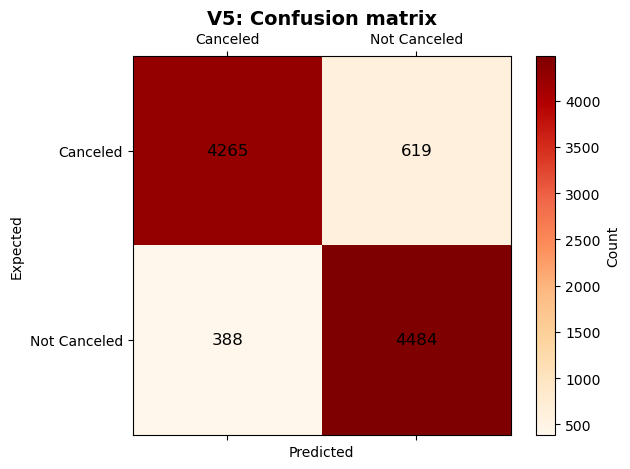

In [ ]:
def plot_confusion_matrix(matrix: pd.DataFrame) -> None:
    """
    Plots a confusion matrix.

    Parameters:
    -----------
        matrix: pd.DataFrame
            The confusion matrix.
    """
    
    labels = ['Canceled', 'Not Canceled']
    fig = plt.figure()
    ax = fig.add_subplot()
    cax = ax.matshow(matrix, cmap=plt.cm.OrRd)
    fig.colorbar(cax, label = 'Count')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, str(matrix[i][j]), 
                    horizontalalignment="center", verticalalignment="center", fontsize=12) 
            
    plt.title('V6: Confusion matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.tight_layout()
    plt.show()

cm = get_confusion_matrix(model, X_test, y_test)
plot_confusion_matrix(cm)

In [ ]:
def get_feature_importance(model: GridSearchCV) -> pd.DataFrame:
    """
    Compute feature importances from the trained machine learning model (RFC).

    Parameters:
    -----------
        model : GridSearchCV
            A trained machine learning estimator with a `feature_importances_` attribute.

    Returns:
    --------
        feature_importance : pd.DataFrame
            A DataFrame containing the top 8 feature importances, a row for all other features, and a normalized importance.

    """

    # Get feature importances and create a DataFrame
    best_estimator = model.best_estimator_
    feature_importance = best_estimator.feature_importances_
    feature_importance = pd.DataFrame({'feature': features.columns, 'importance': feature_importance})

    # Sort feature importances by descending order
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)

    # Create a row for all other features and drop them
    other = feature_importance['importance'].iloc[8:].sum()
    feature_importance = feature_importance.iloc[:8]
    feature_importance = feature_importance.append(pd.Series(['others', other], index=feature_importance.columns), ignore_index=True)

    # Compute relative feature importances
    feature_importance['importance_norm'] = (feature_importance['importance'] / feature_importance['importance'].sum())

    return feature_importance

feature_importance = get_feature_importance(model)

/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_11492/6486396.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importance = feature_importance.append(pd.Series(['others', other], index=feature_importance.columns), ignore_index=True)


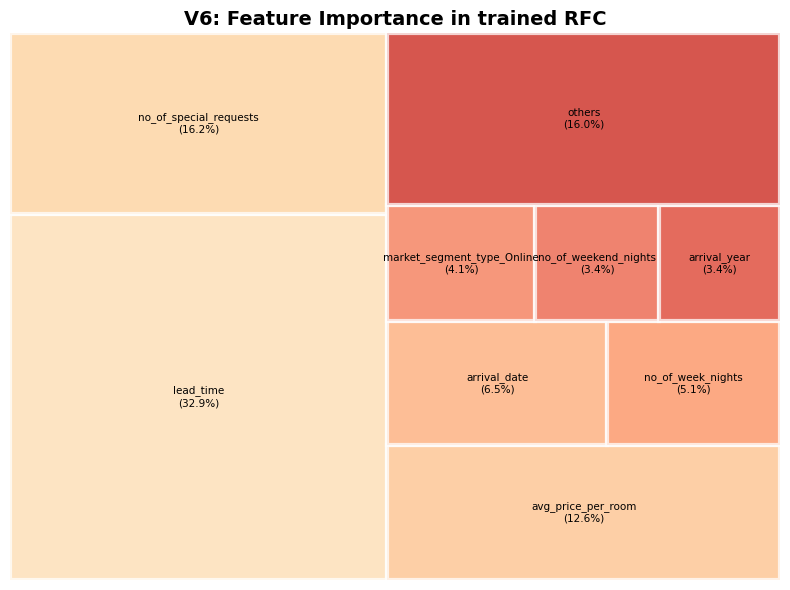

In [ ]:
def plot_feature_importance(feature_importance: pd.DataFrame) -> None:
    """
    Plot the feature importance of the trained model.

    Parameters:
    -----------
        feature_importance : pd.DataFrame
            A DataFrame containing the top 8 feature importances, a row for all other features, and a normalized importance.
    """

    plt.figure(figsize=(8, 6))
    labels = [f"{row['feature']}\n({row['importance_norm']*100:.1f}%)" for i, row in feature_importance.iterrows()]
    squarify.plot(sizes=feature_importance['importance_norm'], 
                  label=labels, 
                  color=plt.get_cmap('OrRd')(np.linspace(0.2, 0.8, 9)),
                  text_kwargs={'fontsize':7.5},
                  edgecolor="white", 
                  linewidth=3, 
                  alpha=0.75)
    plt.title('V7: Feature Importance in trained RFC', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance)